Setup the Environment

In [5]:
!pip install stable-baselines3
!pip install gym
!pip install python-chess
!pip install "shimmy>=2.0"

Import libraries

In [6]:
import chess
import chess.engine
import gym
import numpy as np
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import random
import torch

Create chess environment

In [7]:
class ChessEnv(gym.Env):
    def __init__(self):
        super(ChessEnv, self).__init__()
        self.board = chess.Board()
        self.action_space = spaces.Discrete(4672)
        self.observation_space = spaces.Box(low=0, high=1, shape=(8, 8, 12), dtype=np.float32)

    def reset(self):
        self.board.reset()
        return self.board_to_tensor()

    def step(self, action_index):
        legal_moves = list(self.board.legal_moves)
        done = False
        reward = 0

        if len(legal_moves) == 0:
            return self.board_to_tensor(), -1, True, {}

        move = legal_moves[action_index % len(legal_moves)]
        self.board.push(move)

        # Simple reward
        if self.board.is_checkmate():
            reward = 1
            done = True
        elif self.board.is_stalemate() or self.board.is_insufficient_material():
            reward = 0.5
            done = True

        return self.board_to_tensor(), reward, done, {}

    def render(self, mode='human'):
        print(self.board)

    def board_to_tensor(self):
        tensor = np.zeros((8, 8, 12), dtype=np.float32)
        piece_map = self.board.piece_map()

        for square, piece in piece_map.items():
            row = 7 - chess.square_rank(square)
            col = chess.square_file(square)
            idx = self.piece_index(piece)
            tensor[row, col, idx] = 1

        return tensor

    def piece_index(self, piece):
        return {
            (chess.PAWN, chess.WHITE): 0,
            (chess.KNIGHT, chess.WHITE): 1,
            (chess.BISHOP, chess.WHITE): 2,
            (chess.ROOK, chess.WHITE): 3,
            (chess.QUEEN, chess.WHITE): 4,
            (chess.KING, chess.WHITE): 5,
            (chess.PAWN, chess.BLACK): 6,
            (chess.KNIGHT, chess.BLACK): 7,
            (chess.BISHOP, chess.BLACK): 8,
            (chess.ROOK, chess.BLACK): 9,
            (chess.QUEEN, chess.BLACK): 10,
            (chess.KING, chess.BLACK): 11,
        }[(piece.piece_type, piece.color)]


Training the AI using Proximal Policy Optimization (PPO)

In [33]:
env = DummyVecEnv([lambda: ChessEnv()])

model = PPO("MlpPolicy", env, verbose=1, device="cuda")
model.learn(total_timesteps=100000)  # Increase for stronger model
model.save("ppo_chess_gpu")


Using cuda device
-----------------------------
| time/              |      |
|    fps             | 630  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 512         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.033745237 |
|    clip_fraction        | 0.42        |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.45       |
|    explained_variance   | -0.913      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.139      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.101      |
|    value_loss           | 0.00483     |
-----------------------------------------
----------------

Visualize the results before testing

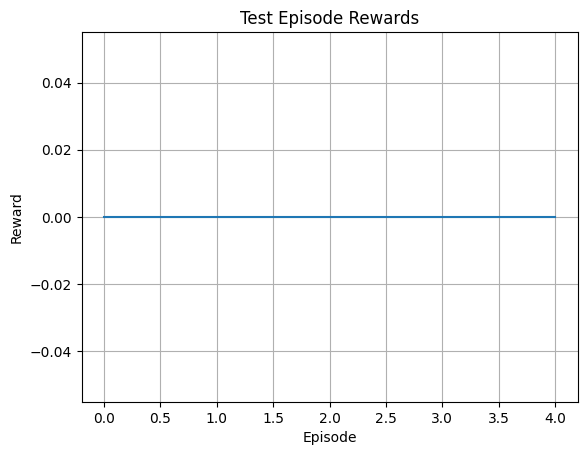

In [28]:
import matplotlib.pyplot as plt

plt.plot(total_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Test Episode Rewards")
plt.grid(True)
plt.show()

Test the AI after training

In [34]:
model = PPO.load("ppo_chess_gpu", device="cuda")
env = ChessEnv()
obs = env.reset()
done = False
step = 0

while not done:
    print(f"\n--- Step {step} ---")
    print("Numerical Input Tensor:")
    print(obs)  # 8x8x12 tensor
    action, _ = model.predict(obs)
    obs, reward, done, info = env.step(action)
    env.render()
    step += 1

print("Final Reward:", reward)


Streaming output truncated to the last 5000 lines.
[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0